## Reactive Covariance - Project in Python 

### I - Leverage Effect in Financial Markets (Paper 1) 


#### 1.1 - With an Index

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os

In [28]:
# Create a Dictionnary with the name of the stocks that we want to plot 

index_dictionnary = {"Ticker1":"voo.us.txt", "Ticker2":"acwf.us.txt", "Ticker3": "adre.us.txt", "Ticker4": "actx.us.txt", "Ticker5": "acwf.us.txt", "Ticker6":"acwi.us.txt", "Ticker7":"acwx.us.txt","Ticker8":"adrd.us.txt"} ## Création d'un dictionnaire comportant les tickers des index 
stock_dictionnary = {"Ticker1": "aac.us.txt"} ## Dictionnaire avec le nom des stocks

In [29]:
## Le but de cette classe est de regrouper les méthodes permettant le calcul du leverage
## L'idée est ensuite de pouvoir calculer rapidement le leverage en loopant sur des centaines de stocks et indices 

class ComputeLeverage: 
    
    def __init__(self): ## Méthode du constructeur
        self.ticker = Ticker ## on construit l'objet prenant comme parametre le ticker du stock
        self.security = Security
        self.df = pd.read_csv(os.path.join("Data\\", self.security, self.ticker),delimiter=',',usecols=['Date','Open','High','Low','Close']) # This is an S&P 500 ETF
        # On importe les données dans la construction de l'objet. La dataframe "df" sera utilisee par les autres méthodes de la classe
        
    def sortData(self):
        self.df = self.df.sort_values("Date") # sort the data by date
        return self.df.head()
    
    def deltaTau(self,tau): # Cette fonction calcule la variation du prix entre t et t + tau (delta x(t+tau)) 
        return (self.df["Close"].shift(-tau) - self.df["Close"].shift(-tau+1))/self.df["Close"].shift(-tau+1)
    
    def zHat(self,tau,T): # Cette fonction calcule Z chapeau
        self.df["Interm_Z"] = (self.deltaTau(tau)**2)  # Calcule l'intérieur de la somme 
        return ((1/T)*(self.df["Interm_Z"].sum())**2) # Retourne la somme des carrés normalisé par T
        
    def lHat(self,tau,T):
        self.df["Interm_Prod_Delta"]  = (self.deltaTau(tau))**2*self.deltaTau(0)
        return ((1/(self.zHat(tau,T)*(T-tau)))*self.df["Interm_Prod_Delta"].sum())
    
    def PlotLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(0,250): ## specify the max range for the time horizon 
             result_df = result_df.append(pd.DataFrame({"Tau":tau,'L_Hat': self.lHat(tau,T)}, index=[0]), ignore_index=True)
                
        return result_df.plot.scatter(x = "Tau", y = "L_Hat" )
    
    ## C'est exactement la même méthode qu'au dessus. La seule différence est qu'elle retourne le résultat sous forme de tableau et non de graph
    def ReturnLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(0,250): ## specify the max range for the time horizon 
            result_df = result_df.append(pd.DataFrame({"Tau":tau,'L_Hat': self.lHat(tau,T)}, index=[0]), ignore_index=True)
        return result_df

voo.us.txt
acwf.us.txt
adre.us.txt
actx.us.txt
acwf.us.txt
acwi.us.txt
acwx.us.txt
adrd.us.txt


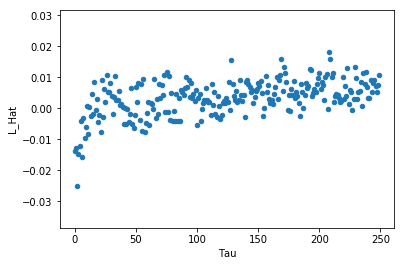

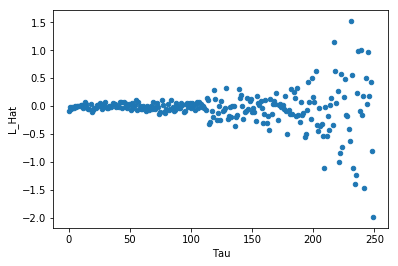

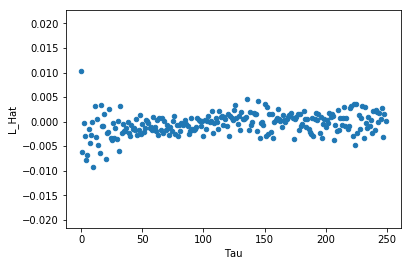

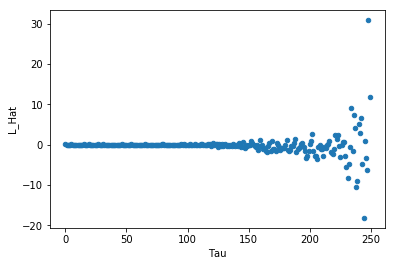

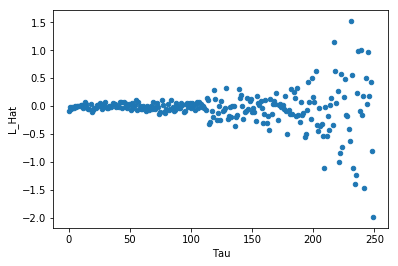

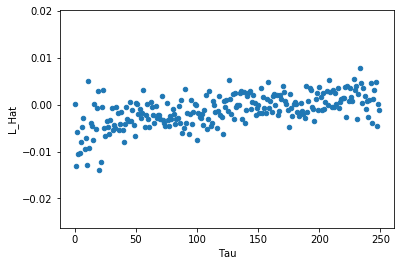

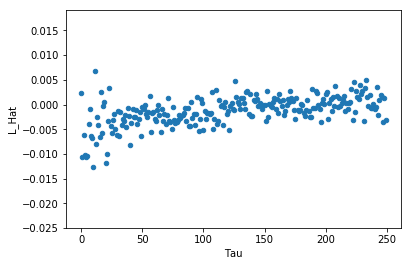

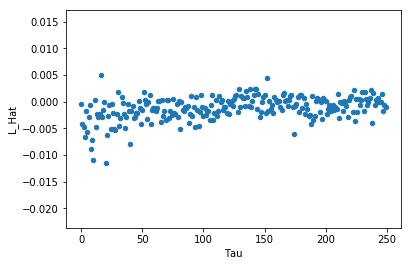

In [30]:
Tau = 250  ## On spécifie ici l'horizon de temps qui sera calculé au sein de la classe 
Security = "ETFs" ## Change to "Stocks" pour calculer le leverage des stocks. 
                  ## Cela change le répertoire d'importation des donnees dans la création de la classe

leverage_df = pd.DataFrame([])

if (Security == "ETFs"):
    my_dictionnary = index_dictionnary
else:
    my_dictionnary = stock_dictionnary


for key in my_dictionnary:
    Ticker = my_dictionnary.get(key) ## définition du ticker pour la création de l'objet
    myStock = ComputeLeverage() ## Creation de l'objet 
    myStock.PlotLeverage() ## On appelle la methode qui trace le graph
    #leverage_df = myStock.ReturnLeverage()
    print(my_dictionnary.get(key))
    #leverage_df = leverage_df.append(pd.DataFrame({"Stock": key, "Leverage": myStock.ReturnLeverage()}, index=[0], ignore_index=True)
                                    